In [1]:
from pandas import read_csv
import numpy as np
from ucla.core.constants import *
from ucla.core.local_ODE_solver import LocalModel
from ucla.core.physics import SMT

import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

from average_atom.core.physics import More_TF_Zbar
eV_to_J = eV_to_AU*AU_to_J


### Argon based on Chris Fontes 

In [2]:
Te_eV = 2 #eV
ne_invcc = 1e20
Zbar = 0.381
nn_invcc = ne_invcc/Zbar
Ar_nn_invcc = nn_invcc

In [5]:
element='Ar'

if element=='Ar':
    Z, A = 18, 39.948
    m_i = A*m_p
    mi_kg = m_i
    nn_invm3 = nn_invcc*1e6
    ne_invm3 = ne_invcc*1e6
    ρi_kginvm3 = m_i*nn_invm3
    ri = 1/(4/3*π*nn_invm3)**(1/3)*m_to_AU

    Zi_array = np.array([1, 2])
    
    Ti_K = 0
    Te_K = Te_eV*eV_to_K
    
    χ0_eV = 15.7596119  # eV See 
    χ0_J = χ0_eV*eV_to_J

    # ionization_file="../../data/Ar25bar_Saha.txt"
    saha_eos_file = "/home/zach/plasma/saha/data/Ar25bar_Saha.txt"
    element_data_file = "../../data/experimental_data/Ar_25bar_Te.txt"

    

In [21]:
def get_κ_absorption(Eγ_eV):
    ω_invs = Eγ_eV*eV_to_J/hbar
    κ_invm = SMT.photon_absorption_coefficient(ω_invs, mi_kg, Zbar*nn_invm3, ne_invm3, Ti_K, Te_K)
    return κ_invm



def get_κ_absorption_new(Eγ_eV, x1 = Zbar): 
    """
    γ = ne/nc
    νei = 2.91e-12*Te_eV**-1.5 * Σ_i( Z_i**2 n_i lnΛ_i)
    Λ_i(D&D) = ln( 1 + 0.7* λDe_AU Te_AU/Z ) 
    κ_invm = νei γ/c /sqrt(1-γ) fl fsc
    """
    xi_array = np.array([ x1, (Zbar - x1)/2 ])
    ni_invm3_array = nn_invm3 * xi_array * Zi_array

    ω_invs = Eγ_eV*eV_to_J/hbar
    ωpe = SMT.electron_plasma_frequency(ne_invm3)
    γ = (ωpe/ω_invs)**2 # γ = ne/nc = ωpe^2/ω^2
    λDe = SMT.electron_thermal_velocity(Te_eV*eV_to_K)/np.sqrt(3)/ωpe # they define without sqrt(3) 
    lnΛi = np.log( 1 + 0.7 * λDe*m_to_AU * Te_eV*eV_to_AU/Zi_array)
    νei =  2.91e-12*Te_eV**-1.5 * np.sum( Zi_array**2 * ni_invm3_array * lnΛi  ) 
    κ_invm = νei * γ/c/np.sqrt( 1 - γ)
    return κ_invm

def λ_nm_to_Eγ(λ_nm):
    λ_m = λ_nm*1e-9
    ν = c/λ_m
    ω = ν*2*π
    return ω*hbar*J_to_eV
    
get_κ_absorption_new(1)

35886.27692936023

In [22]:
CF_dir = "/home/zach/plasma/ucla/data/CF_Collisional_Radiative/"
ff_opacity_data = read_csv(CF_dir + "Ar_Te=2eV_ne=1e20/opacity/opac_ar_2ev_0ev_1e20cc_01_03_CL_5000pts_free-free.txt", delim_whitespace=True, header=0)
bf_opacity_data = read_csv(CF_dir + "Ar_Te=2eV_ne=1e20/opacity/opac_ar_2ev_0ev_1e20cc_01_03_CL_5000pts_free-bound.txt", delim_whitespace=True, header=0)
bb_opacity_data = read_csv(CF_dir + "Ar_Te=2eV_ne=1e20/opacity/opac_ar_2ev_0ev_1e20cc_01_03_CL_5000pts_bound-bound.txt", delim_whitespace=True, header=0)

bb_opacity_Eγ_eV = bb_opacity_data['E_γ[eV]']
bb_opacity_κ_invm = ρi_kginvm3*bb_opacity_data['opacity[cm^2/g]']*1e3*1e-4 # kg/m^3 x m^2/g = 1/m

bf_opacity_Eγ_eV = bf_opacity_data['E_γ[eV]']
bf_opacity_κ_invm = ρi_kginvm3*bf_opacity_data['opacity[cm^2/g]']*1e3*1e-4 # kg/m^3 x m^2/g = 1/m

ff_opacity_Eγ_eV = ff_opacity_data['E_γ[eV]']
ff_opacity_κ_invm = ρi_kginvm3*ff_opacity_data['opacity[cm^2/g]']*1e3*1e-4 # kg/m^3 x m^2/g = 1/m

/tmp/ipykernel_3459150/2146799702.py:24: RuntimeWarning: invalid value encountered in sqrt
  κ_invm = νei * γ/c/np.sqrt( 1 - γ)


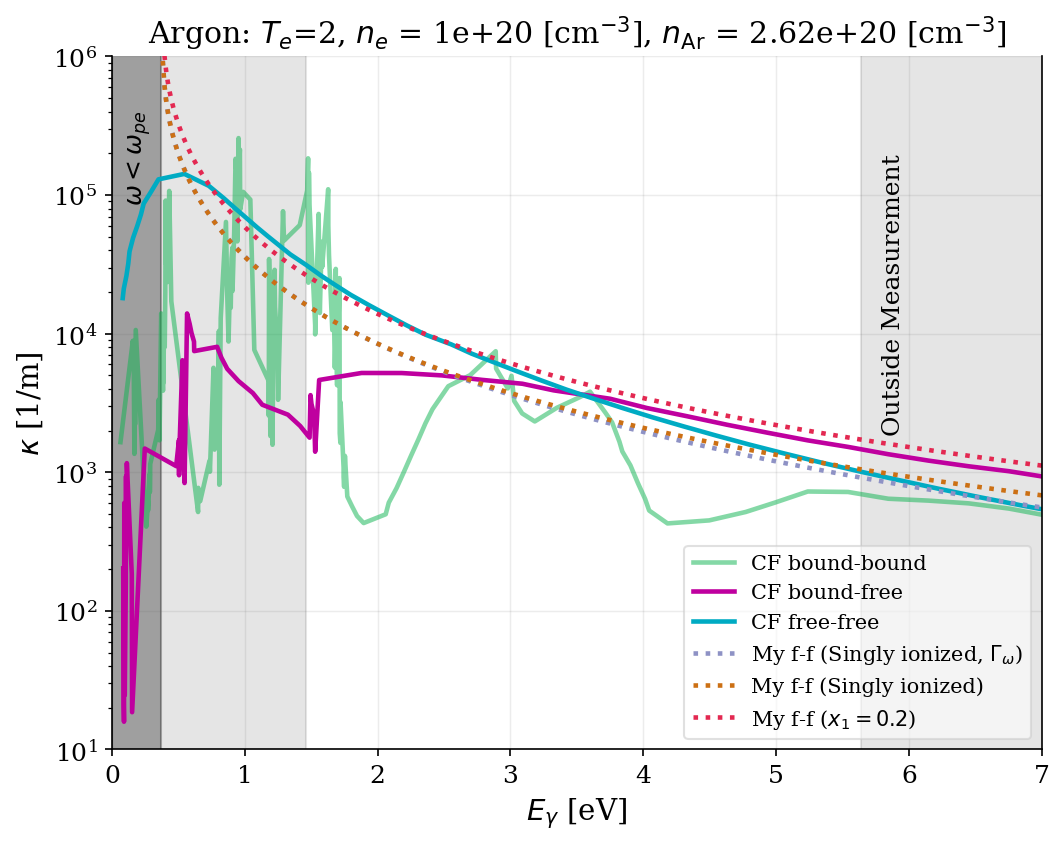

In [28]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

ax.set_title(r"Argon: $T_e$={0}, $n_e$ = {1} [cm$^{{-3}}$], $n_{{\rm Ar}}$ = {2:0.2e} [cm$^{{-3}}$]".format(Te_eV, ne_invcc, nn_invcc ))
ax.plot(bb_opacity_Eγ_eV , bb_opacity_κ_invm, label= "CF bound-bound", alpha=0.5 ) 
ax.plot(bf_opacity_Eγ_eV , bf_opacity_κ_invm, label= "CF bound-free" ) 
ax.plot(ff_opacity_Eγ_eV , ff_opacity_κ_invm, label= "CF free-free" ) 

Eγ_eV_array= np.geomspace(1e-1,50, num=200) 
ax.plot(Eγ_eV_array , get_κ_absorption(Eγ_eV_array),':', label="My f-f (Singly ionized, $\Gamma_\omega $)") 
ax.plot(Eγ_eV_array , get_κ_absorption_new(Eγ_eV_array),':', label="My f-f (Singly ionized)") 
ax.plot(Eγ_eV_array , get_κ_absorption_new(Eγ_eV_array, x1=0.2),':', label=r"My f-f ($x_1=0.2$)") 

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$E_\gamma$ [eV]")
ax.set_ylabel(r"$\kappa$ [1/m]")
ax.set_xlim(0,7)
ax.set_ylim(1e1,1e6)

E_pe = SMT.electron_plasma_frequency(ne_invm3)*hbar*J_to_eV
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, E_pe, color='k', alpha=0.3)
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, λ_nm_to_Eγ(850), color='k', alpha=0.1)
ax.fill_betweenx(np.linspace(0,1e8, num=2), λ_nm_to_Eγ(220), 200, color='k', alpha=0.1)

ax.text(5.8,0.2e4, "Outside Measurement", rotation=90)
ax.text(0.1,1e5, r"$\omega < \omega_{pe}$", rotation=90)

# ax.set_ylim(0,1e4)
ax.legend(loc='lower right')